# Flight Delay Prediction
to predict flight delays using historical data.

In [66]:
import pandas as pd
import numpy as np
#load libraries

In [67]:
import pandas as pd
#load data
df=pd.read_csv('C:\\Users\\smabu\\.cache\\kagglehub\\datasets\\sriharshaeedala\\airline-delay\\versions\\1\\Airline_Delay_Cause.csv')
print('Data loaded successfully. Shape:', df.shape)

Data loaded successfully. Shape: (171666, 21)


# Exploratory Data Analysis

In [68]:
import pandas as pd
#basic summary statistics
print('Summary Statistics:')
print(df.describe())

Summary Statistics:
                year          month    arr_flights      arr_del15  \
count  171666.000000  171666.000000  171426.000000  171223.000000   
mean     2018.551361       6.493633     362.528467      66.434387   
std         2.890006       3.440908     992.894662     179.540694   
min      2013.000000       1.000000       1.000000       0.000000   
25%      2016.000000       4.000000      50.000000       6.000000   
50%      2019.000000       7.000000     100.000000      17.000000   
75%      2021.000000       9.000000     250.000000      47.000000   
max      2023.000000      12.000000   21977.000000    4176.000000   

          carrier_ct     weather_ct         nas_ct    security_ct  \
count  171426.000000  171426.000000  171426.000000  171426.000000   
mean       20.796615       2.250347      19.381147       0.157096   
std        50.315176       7.314252      61.675244       0.717405   
min         0.000000       0.000000       0.000000       0.000000   
25%         2

In [69]:
import pandas as pd
#check missing values
print('Missing Values:')
print(df.isnull().sum())

Missing Values:
year                     0
month                    0
carrier                  0
carrier_name             0
airport                  0
airport_name             0
arr_flights            240
arr_del15              443
carrier_ct             240
weather_ct             240
nas_ct                 240
security_ct            240
late_aircraft_ct       240
arr_cancelled          240
arr_diverted           240
arr_delay              240
carrier_delay          240
weather_delay          240
nas_delay              240
security_delay         240
late_aircraft_delay    240
dtype: int64


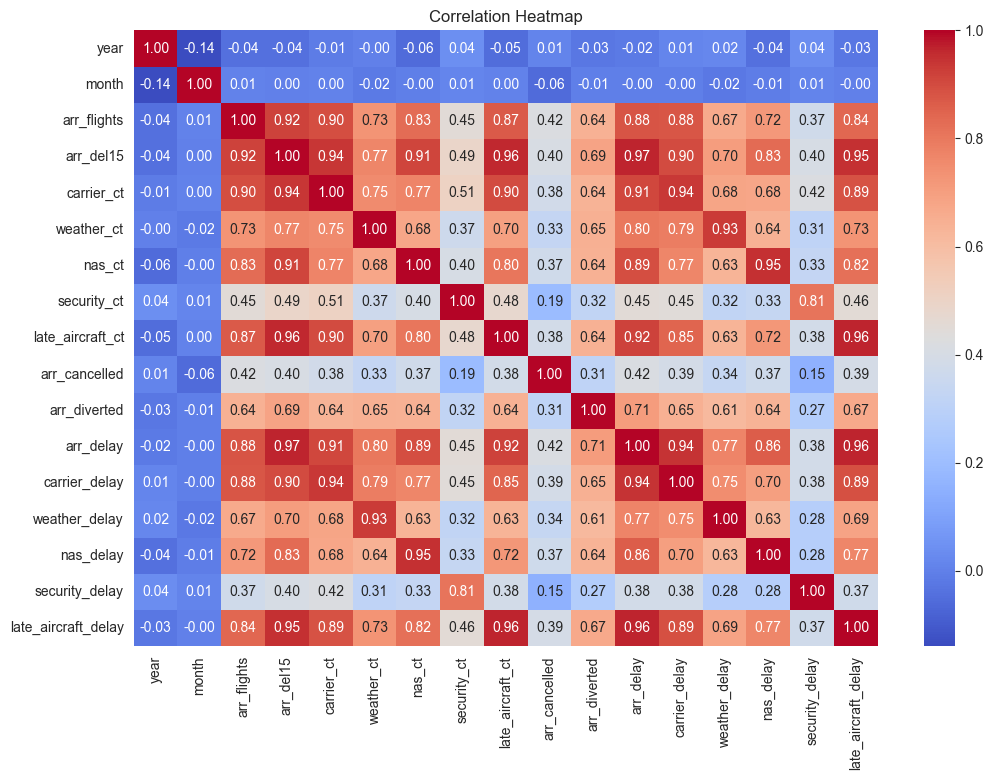

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
#correlation heatmap
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

In [71]:
import pandas as pd
#remove covid years FIRST
if 'year' in df.columns:
    before_shape=df.shape
    df=df[~df['year'].isin([2020,2021])].copy()
    print(f"Removed COVID years: {before_shape} -> {df.shape}")
    print(f"Years remaining: {sorted(df['year'].unique())}")
#handle missing values
if 'arr_del15' in df.columns:
    target_missing=df['arr_del15'].isnull().sum()
    if target_missing>0:
        df=df.dropna(subset=['arr_del15'])
        print(f"Dropped {target_missing} rows with missing targets")
if 'arr_flights' in df.columns and df['arr_flights'].isnull().sum()>0:
    df['arr_flights']=df.groupby(['carrier','airport'])['arr_flights'].transform(lambda x:x.fillna(x.median()))
    df['arr_flights']=df['arr_flights'].fillna(df['arr_flights'].median())
for col in ['arr_cancelled','arr_diverted']:
    if col in df.columns:
        df[col]=df[col].fillna(0)
print(f"Missing values after: {df.isnull().sum().sum()}")

Removed COVID years: (171666, 21) -> (132853, 21)
Years remaining: [np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2022), np.int64(2023)]
Dropped 158 rows with missing targets
Missing values after: 0


In [72]:
import pandas as pd
import numpy as np
#extract signal features before dropping leaky columns
if 'arr_delay' in df.columns and 'arr_flights' in df.columns:
    df['avg_delay_minutes']=df['arr_delay']/df['arr_flights']
    df['avg_delay_minutes']=df['avg_delay_minutes'].fillna(0)
    print(f"Created avg_delay_minutes (mean: {df['avg_delay_minutes'].mean():.2f} min)")
if all(col in df.columns for col in ['carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay','arr_delay']):
    total_delay=df['arr_delay'].replace(0,np.nan)
    df['carrier_delay_pct']=(df['carrier_delay']/total_delay*100).fillna(0)
    df['weather_delay_pct']=(df['weather_delay']/total_delay*100).fillna(0)
    df['nas_delay_pct']=(df['nas_delay']/total_delay*100).fillna(0)
    df['security_delay_pct']=(df['security_delay']/total_delay*100).fillna(0)
    df['late_aircraft_delay_pct']=(df['late_aircraft_delay']/total_delay*100).fillna(0)
    print("Created delay percentage features")
if 'weather_ct' in df.columns:
    df['weather_impact_occurred']=(df['weather_ct']>0).astype(int)
if 'nas_ct' in df.columns:
    df['system_congestion_occurred']=(df['nas_ct']>0).astype(int)
if 'late_aircraft_ct' in df.columns:
    df['cascade_delay_occurred']=(df['late_aircraft_ct']>0).astype(int)
if 'carrier_ct' in df.columns:
    df['carrier_issues_occurred']=(df['carrier_ct']>0).astype(int)
if 'security_ct' in df.columns:
    df['security_incident_occurred']=(df['security_ct']>0).astype(int)
leaky_columns=['carrier_ct','weather_ct','nas_ct','security_ct','late_aircraft_ct','carrier_delay','weather_delay','nas_delay','security_delay','late_aircraft_delay']
existing_leaky=[col for col in leaky_columns if col in df.columns]
df=df.drop(columns=existing_leaky,errors='ignore')
print(f"Dropped leaky columns: {existing_leaky}")
print(f"Shape after: {df.shape}")

Created avg_delay_minutes (mean: 12.37 min)
Created delay percentage features
Dropped leaky columns: ['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct', 'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']
Shape after: (132695, 22)


In [73]:
import pandas as pd
#drop unnecessary columns
df=df.drop(columns=['carrier_name', 'airport_name'] if 'carrier_name' in df.columns else [])
print('Columns after dropping unnecessary ones:', df.columns.tolist())

Columns after dropping unnecessary ones: ['year', 'month', 'carrier', 'airport', 'arr_flights', 'arr_del15', 'arr_cancelled', 'arr_diverted', 'arr_delay', 'avg_delay_minutes', 'carrier_delay_pct', 'weather_delay_pct', 'nas_delay_pct', 'security_delay_pct', 'late_aircraft_delay_pct', 'weather_impact_occurred', 'system_congestion_occurred', 'cascade_delay_occurred', 'carrier_issues_occurred', 'security_incident_occurred']


In [74]:
import pandas as pd
#create mappings
CARRIER_NAMES=dict(df[['carrier','carrier_name']].drop_duplicates().values) if 'carrier_name' in df.columns else {carrier:carrier for carrier in df['carrier'].unique()}
AIRPORT_NAMES=dict(df[['airport','airport_name']].drop_duplicates().values) if 'airport_name' in df.columns else {airport:airport for airport in df['airport'].unique()}
HISTORICAL_DATA=df.copy()
print('Carrier Names Mapping (first 5):', dict(list(CARRIER_NAMES.items())[:5]))
print('Airport Names Mapping (first 5):', dict(list(AIRPORT_NAMES.items())[:5]))

Carrier Names Mapping (first 5): {'9E': '9E', 'AA': 'AA', 'AS': 'AS', 'B6': 'B6', 'DL': 'DL'}
Airport Names Mapping (first 5): {'ABE': 'ABE', 'ABY': 'ABY', 'AEX': 'AEX', 'AGS': 'AGS', 'ALB': 'ALB'}


In [75]:
import pandas as pd
import numpy as np
#temporal features
baseline_year=df['year'].min()
df['month_sin']=np.sin(2*np.pi*df['month']/12)
df['month_cos']=np.cos(2*np.pi*df['month']/12)
df['years_since_baseline']=df['year']-baseline_year
df['holiday_period']=df['month'].isin([6,7,11,12]).astype(int)
df['peak_summer']=df['month'].isin([6,7,8]).astype(int)
df['winter_weather_season']=df['month'].isin([12,1,2,3]).astype(int)
print('Temporal Features Summary:')
print(df[['month_sin', 'month_cos', 'years_since_baseline', 'holiday_period', 'peak_summer', 'winter_weather_season']].describe())

Temporal Features Summary:
          month_sin     month_cos  years_since_baseline  holiday_period  \
count  1.326950e+05  1.326950e+05         132695.000000   132695.000000   
mean  -7.351501e-03 -1.038468e-02              4.978469        0.331271   
std    7.077158e-01  7.063880e-01              3.043700        0.470672   
min   -1.000000e+00 -1.000000e+00              0.000000        0.000000   
25%   -8.660254e-01 -5.000000e-01              2.000000        0.000000   
50%   -2.449294e-16 -1.836970e-16              5.000000        0.000000   
75%    5.000000e-01  5.000000e-01              6.000000        1.000000   
max    1.000000e+00  1.000000e+00             10.000000        1.000000   

         peak_summer  winter_weather_season  
count  132695.000000          132695.000000  
mean        0.261705               0.329500  
std         0.439565               0.470033  
min         0.000000               0.000000  
25%         0.000000               0.000000  
50%         0.000000 

In [76]:
import pandas as pd
#operational features
df['flight_volume_category']=pd.cut(df['arr_flights'],bins=[0,50,200,500,float('inf')],labels=['small','medium','large','major_hub'])
df['flight_volume_percentile']=df['arr_flights'].rank(pct=True)
airport_max_flights=df.groupby('airport')['arr_flights'].transform('max')
df['capacity_utilization']=df['arr_flights']/airport_max_flights
print('Operational Features Summary:')
print(df[['flight_volume_category', 'flight_volume_percentile', 'capacity_utilization']].describe())
print('Flight Volume Category Counts:')
print(df['flight_volume_category'].value_counts())

Operational Features Summary:
       flight_volume_percentile  capacity_utilization
count             132695.000000         132695.000000
mean                   0.500004              0.280293
std                    0.288667              0.272099
min                    0.003278              0.000046
25%                    0.248736              0.058728
50%                    0.498904              0.178161
75%                    0.750002              0.440129
max                    1.000000              1.000000
Flight Volume Category Counts:
flight_volume_category
medium       59876
small        30203
large        22890
major_hub    19726
Name: count, dtype: int64


In [77]:
import pandas as pd
import numpy as np
#stress indicators
df['cancellation_rate']=np.where(df['arr_flights']>0,df['arr_cancelled']/df['arr_flights'],0)
df['diversion_rate']=np.where(df['arr_flights']>0,df['arr_diverted']/df['arr_flights'],0)
df['diversion_occurred']=(df['arr_diverted']>0).astype(int)
df['total_disruption_rate']=df['cancellation_rate']+df['diversion_rate']
df['operational_stress_level']=pd.cut(df['total_disruption_rate'],bins=[0,0.01,0.05,0.15,float('inf')],labels=['low','moderate','high','severe'])
print('Stress Indicators Summary:')
print(df[['cancellation_rate', 'diversion_rate', 'diversion_occurred', 'total_disruption_rate']].describe())
print('Operational Stress Level Counts:')
print(df['operational_stress_level'].value_counts())

Stress Indicators Summary:
       cancellation_rate  diversion_rate  diversion_occurred  \
count      132695.000000   132695.000000       132695.000000   
mean            0.018933        0.002859            0.288692   
std             0.034890        0.010005            0.453156   
min             0.000000        0.000000            0.000000   
25%             0.000000        0.000000            0.000000   
50%             0.005831        0.000000            0.000000   
75%             0.024000        0.001495            1.000000   
max             0.866667        0.666667            1.000000   

       total_disruption_rate  
count          132695.000000  
mean                0.021792  
std                 0.036628  
min                 0.000000  
25%                 0.000000  
50%                 0.009434  
75%                 0.029091  
max                 0.866667  
Operational Stress Level Counts:
operational_stress_level
moderate    48464
low         20678
high        14909
sever

In [78]:
import pandas as pd
#historical features
df['carrier_airport_combo']=df['carrier']+'_'+df['airport']
carrier_delay_rate=df.groupby('carrier')['arr_del15'].sum()/df.groupby('carrier')['arr_flights'].sum()
df['carrier_historical_delay_rate']=df['carrier'].map(carrier_delay_rate)
airport_delay_rate=df.groupby('airport')['arr_del15'].sum()/df.groupby('airport')['arr_flights'].sum()
df['airport_historical_delay_rate']=df['airport'].map(airport_delay_rate)
seasonal_performance=df.groupby(['carrier','airport','month']).agg({'arr_del15':'sum','arr_flights':'sum'}).reset_index()
seasonal_performance['seasonal_delay_rate']=seasonal_performance['arr_del15']/seasonal_performance['arr_flights']
df=df.merge(seasonal_performance[['carrier','airport','month','seasonal_delay_rate']],on=['carrier','airport','month'],how='left')
print(f"Merged seasonal_delay_rate, shape: {df.shape}")
if all(col in df.columns for col in ['carrier_delay_pct','weather_delay_pct','nas_delay_pct','late_aircraft_delay_pct']):
    delay_breakdown=df.groupby(['carrier','airport','month']).agg({'carrier_delay_pct':'mean','weather_delay_pct':'mean','nas_delay_pct':'mean','security_delay_pct':'mean','late_aircraft_delay_pct':'mean'}).reset_index()
    delay_breakdown.columns=['carrier','airport','month','avg_carrier_pct','avg_weather_pct','avg_nas_pct','avg_security_pct','avg_late_aircraft_pct']
    df=df.merge(delay_breakdown,on=['carrier','airport','month'],how='left')
    print(f"Merged delay breakdown, shape: {df.shape}")
print('Historical Features Summary:')
print(df[['carrier_historical_delay_rate','airport_historical_delay_rate','seasonal_delay_rate']].describe())

Merged seasonal_delay_rate, shape: (132695, 38)
Merged delay breakdown, shape: (132695, 43)
Historical Features Summary:
       carrier_historical_delay_rate  airport_historical_delay_rate  \
count                  132695.000000                  132695.000000   
mean                        0.196380                       0.192794   
std                         0.034205                       0.027553   
min                         0.130044                       0.000000   
25%                         0.177386                       0.179379   
50%                         0.196835                       0.197152   
75%                         0.206990                       0.206853   
max                         0.270266                       1.000000   

       seasonal_delay_rate  
count        132695.000000  
mean              0.199024  
std               0.069224  
min               0.000000  
25%               0.153670  
50%               0.193767  
75%               0.239637  
max    

In [79]:
import pandas as pd
#interaction features
df['carrier_peak_risk']=df['carrier_historical_delay_rate']*df['peak_summer']
df['carrier_winter_risk']=df['carrier_historical_delay_rate']*df['winter_weather_season']
df['airport_holiday_risk']=df['airport_historical_delay_rate']*df['holiday_period']
print('Interaction Features Summary:')
print(df[['carrier_peak_risk', 'carrier_winter_risk', 'airport_holiday_risk']].describe())

Interaction Features Summary:
       carrier_peak_risk  carrier_winter_risk  airport_holiday_risk
count      132695.000000        132695.000000         132695.000000
mean            0.051461             0.064655              0.063836
std             0.088208             0.094283              0.092063
min             0.000000             0.000000              0.000000
25%             0.000000             0.000000              0.000000
50%             0.000000             0.000000              0.000000
75%             0.144972             0.177386              0.179157
max             0.270266             0.270266              0.365256


In [80]:
import pandas as pd
import numpy as np
#cap extreme outliers at 99th percentile
delay_cols=['arr_delay','carrier_delay','weather_delay','nas_delay','late_aircraft_delay']
for col in delay_cols:
    if col in df.columns:
        cap_value=df[col].quantile(0.99)
        df[col]=df[col].clip(upper=cap_value)
print(f'capped delay columns at 99th percentile')

#log transform skewed features
skewed_cols=['arr_flights','arr_del15','arr_cancelled','arr_diverted']
for col in skewed_cols:
    if col in df.columns:
        df[f'{col}_log']=np.log1p(df[col])
print(f'created log transformed features')

#reduce high cardinality in carrier_airport_combo
if 'carrier_airport_combo' in df.columns:
    combo_counts=df['carrier_airport_combo'].value_counts()
    rare_combos=combo_counts[combo_counts<10].index
    df.loc[df['carrier_airport_combo'].isin(rare_combos),'carrier_airport_combo']='Other'
    print(f'grouped {len(rare_combos)} rare carrier_airport_combos into Other')
    
#remove duplicate percentage features
duplicate_cols=['carrier_delay_pct','weather_delay_pct','nas_delay_pct','security_delay_pct','late_aircraft_delay_pct']
df=df.drop(columns=[col for col in duplicate_cols if col in df.columns])
print(f'dropped duplicate percentage columns')

print(f'preprocessing complete. shape: {df.shape}')

capped delay columns at 99th percentile
created log transformed features
grouped 263 rare carrier_airport_combos into Other
dropped duplicate percentage columns
preprocessing complete. shape: (132695, 45)


In [81]:
import pandas as pd
#post-preprocessing statistical summary
print('Post-Preprocessing Numerical Features Summary:')
print(df.select_dtypes(include=['int64', 'float64']).describe())
print('Post-Preprocessing Categorical Features Counts:')
for col in df.select_dtypes(include=['category', 'object']).columns:
    print(f'{col} Counts:')
    print(df[col].value_counts())

Post-Preprocessing Numerical Features Summary:
                year          month    arr_flights      arr_del15  \
count  132695.000000  132695.000000  132695.000000  132695.000000   
mean     2017.978469       6.502008     387.829323      74.854682   
std         3.043700       3.430481    1043.535794     192.975588   
min      2013.000000       1.000000       1.000000       0.000000   
25%      2015.000000       4.000000      54.000000       8.000000   
50%      2018.000000       7.000000     111.000000      20.000000   
75%      2019.000000       9.000000     270.000000      54.000000   
max      2023.000000      12.000000   21977.000000    4176.000000   

       arr_cancelled   arr_diverted      arr_delay  avg_delay_minutes  \
count  132695.000000  132695.000000  132695.000000      132695.000000   
mean        6.833679       0.950586    4379.588609          12.374793   
std        29.286971       4.020016    9867.052835           9.872365   
min         0.000000       0.000000    

# Data Splitting

In [82]:
import pandas as pd
#split data
df=df.sort_values(['year','month'])
train_data=df[df['year'].isin([2013,2014,2015,2016,2017,2018])]
val_data=df[df['year'].isin([2019])]
test_data=df[df['year'].isin([2022,2023])]
print('Train Data Shape:', train_data.shape)
print('Validation Data Shape:', val_data.shape)
print('Test Data Shape:', test_data.shape)

Train Data Shape: (79084, 45)
Validation Data Shape: (20927, 45)
Test Data Shape: (32684, 45)


# Encoding and Scaling

In [83]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
#encode categorical features
categorical_features=['carrier','airport','flight_volume_category','operational_stress_level']
encoders={}
train_encoded=train_data.copy()
val_encoded=val_data.copy()
test_encoded=test_data.copy()
for col in categorical_features:
    encoder=LabelEncoder()
    train_encoded[col]=encoder.fit_transform(train_data[col].astype(str))
    encoders[col]=encoder
    val_encoded[col]=pd.Series(-1,index=val_data.index)
    known_labels_mask_val=val_data[col].astype(str).isin(encoder.classes_)
    val_encoded.loc[known_labels_mask_val,col]=encoder.transform(val_data[col].astype(str)[known_labels_mask_val])
    test_encoded[col]=pd.Series(-1,index=test_data.index)
    known_labels_mask_test=test_data[col].astype(str).isin(encoder.classes_)
    test_encoded.loc[known_labels_mask_test,col]=encoder.transform(test_data[col].astype(str)[known_labels_mask_test])
print('Encoded Categorical Features:')
for col in categorical_features:
    print(f'{col} Unique Values in Train:', train_encoded[col].nunique())

Encoded Categorical Features:
carrier Unique Values in Train: 20
airport Unique Values in Train: 369
flight_volume_category Unique Values in Train: 4
operational_stress_level Unique Values in Train: 5


In [84]:
from sklearn.preprocessing import RobustScaler
import pandas as pd
#scale features
exclude_from_model=['arr_del15','arr_flights','flight_volume_percentile','capacity_utilization',
                   'flight_volume_category','carrier_name','airport_name','carrier_airport_combo',
                   'delay_rate','avg_delay_minutes','carrier_delay_pct','weather_delay_pct',
                   'nas_delay_pct','security_delay_pct','late_aircraft_delay_pct']
feature_columns=[col for col in train_data.columns if col not in exclude_from_model]
dont_scale=['year','month','holiday_period','peak_summer','winter_weather_season','diversion_occurred']+categorical_features
features_to_scale=[col for col in feature_columns if col not in dont_scale and train_data[col].dtype in ['int64','float64','int32','float32']]
scaler=RobustScaler()
train_encoded[features_to_scale]=scaler.fit_transform(train_encoded[features_to_scale])
val_encoded[features_to_scale]=scaler.transform(val_encoded[features_to_scale])
test_encoded[features_to_scale]=scaler.transform(test_encoded[features_to_scale])
print('Scaled Features Summary:')
print(train_encoded[features_to_scale].describe())

Scaled Features Summary:
       arr_cancelled  arr_diverted     arr_delay  weather_impact_occurred  \
count   79084.000000  79084.000000  79084.000000             79084.000000   
mean        1.377990      0.996244      1.074031                -0.404545   
std         7.067361      4.149246      3.356154                 0.490807   
min        -0.250000      0.000000     -0.430536                -1.000000   
25%        -0.250000      0.000000     -0.273040                -1.000000   
50%         0.000000      0.000000      0.000000                 0.000000   
75%         0.750000      1.000000      0.726960                 0.000000   
max       347.000000    197.000000     21.645977                 0.000000   

       system_congestion_occurred  cascade_delay_occurred  \
count                79084.000000            79084.000000   
mean                    -0.068080               -0.081432   
std                      0.251884                0.273500   
min                     -1.000000    

In [85]:
print(df.describe().T)

                                  count         mean          std  \
year                           132695.0  2017.978469     3.043700   
month                          132695.0     6.502008     3.430481   
arr_flights                    132695.0   387.829323  1043.535794   
arr_del15                      132695.0    74.854682   192.975588   
arr_cancelled                  132695.0     6.833679    29.286971   
arr_diverted                   132695.0     0.950586     4.020016   
arr_delay                      132695.0  4379.588609  9867.052835   
avg_delay_minutes              132695.0    12.374793     9.872365   
weather_impact_occurred        132695.0     0.596880     0.490526   
system_congestion_occurred     132695.0     0.903907     0.294719   
cascade_delay_occurred         132695.0     0.906545     0.291070   
carrier_issues_occurred        132695.0     0.946840     0.224352   
security_incident_occurred     132695.0     0.128015     0.334108   
month_sin                      132

# Target Preparation

In [86]:
import pandas as pd
import numpy as np
#prepare targets
train_encoded['delay_rate']=np.where(train_encoded['arr_flights']>0,train_encoded['arr_del15']/train_encoded['arr_flights'],0)
val_encoded['delay_rate']=np.where(val_encoded['arr_flights']>0,val_encoded['arr_del15']/val_encoded['arr_flights'],0)
test_encoded['delay_rate']=np.where(test_encoded['arr_flights']>0,test_encoded['arr_del15']/test_encoded['arr_flights'],0)

#add log features to feature columns
log_features=['arr_flights_log','arr_del15_log','arr_cancelled_log','arr_diverted_log']
for col in log_features:
    if col in train_encoded.columns and col not in feature_columns:
        feature_columns.append(col)
print(f'Total features: {len(feature_columns)}')

y_train=train_encoded['delay_rate'].values
y_val=val_encoded['delay_rate'].values
y_test=test_encoded['delay_rate'].values
X_train=train_encoded[feature_columns]
X_val=val_encoded[feature_columns]
X_test=test_encoded[feature_columns]
print('Target (delay_rate) Summary:')
print('Train:', pd.Series(y_train).describe())
print('Validation:', pd.Series(y_val).describe())
print('Test:', pd.Series(y_test).describe())

Total features: 38
Target (delay_rate) Summary:
Train: count    79084.000000
mean         0.191762
std          0.103969
min          0.000000
25%          0.125000
50%          0.179775
75%          0.245601
max          1.000000
dtype: float64
Validation: count    20927.000000
mean         0.194419
std          0.103719
min          0.000000
25%          0.129032
50%          0.185629
75%          0.248705
max          1.000000
dtype: float64
Test: count    32684.000000
mean         0.213622
std          0.115239
min          0.000000
25%          0.137603
50%          0.200000
75%          0.273877
max          1.000000
dtype: float64


# Model Training

In [87]:
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
import pandas as pd
import time
#train models
models={}
predictions={}
print('Starting Ridge training...')
start_time = time.time()
ridge=Ridge(alpha=1.0,random_state=42)
ridge.fit(X_train,y_train)
models['Ridge']=ridge
predictions['ridge_train']=np.clip(ridge.predict(X_train),0,1)
predictions['ridge_val']=np.clip(ridge.predict(X_val),0,1)
print(f'Ridge training completed in {time.time() - start_time:.2f} seconds')
print('Starting Decision Tree training...')
start_time = time.time()
dt=DecisionTreeRegressor(max_depth=10,min_samples_split=15,min_samples_leaf=8,random_state=42)
dt.fit(X_train,y_train)
models['Decision Tree']=dt
predictions['dt_train']=np.clip(dt.predict(X_train),0,1)
predictions['dt_val']=np.clip(dt.predict(X_val),0,1)
print(f'Decision Tree training completed in {time.time() - start_time:.2f} seconds')
print('Starting Random Forest training...')
start_time = time.time()
rf=RandomForestRegressor(n_estimators=150,max_depth=12,min_samples_split=8,min_samples_leaf=4,random_state=42,n_jobs=-1)
rf.fit(X_train,y_train)
models['Random Forest']=rf
predictions['rf_train']=np.clip(rf.predict(X_train),0,1)
predictions['rf_val']=np.clip(rf.predict(X_val),0,1)
print(f'Random Forest training completed in {time.time() - start_time:.2f} seconds')
print('Starting KNN training...')
start_time = time.time()
knn=KNeighborsRegressor(n_neighbors=25,weights='distance',n_jobs=-1)
knn.fit(X_train,y_train)
models['KNN']=knn
predictions['knn_train']=np.clip(knn.predict(X_train),0,1)
predictions['knn_val']=np.clip(knn.predict(X_val),0,1)
print(f'KNN training completed in {time.time() - start_time:.2f} seconds')
print('Starting Extra Trees training...')
start_time = time.time()
et=ExtraTreesRegressor(n_estimators=120,max_depth=10,min_samples_split=12,min_samples_leaf=6,random_state=42,n_jobs=-1)
et.fit(X_train,y_train)
models['Extra Trees']=et
predictions['et_train']=np.clip(et.predict(X_train),0,1)
predictions['et_val']=np.clip(et.predict(X_val),0,1)
print(f'Extra Trees training completed in {time.time() - start_time:.2f} seconds')
print('Starting Gradient Boosting training...')
start_time = time.time()
gb=GradientBoostingRegressor(n_estimators=100,learning_rate=0.05,max_depth=5,min_samples_split=20,min_samples_leaf=10,subsample=0.8,random_state=42)
gb.fit(X_train,y_train)
models['Gradient Boosting']=gb
predictions['gb_train']=np.clip(gb.predict(X_train),0,1)
predictions['gb_val']=np.clip(gb.predict(X_val),0,1)
print(f'Gradient Boosting training completed in {time.time() - start_time:.2f} seconds')
print('All models trained successfully.')

Starting Ridge training...
Ridge training completed in 0.11 seconds
Starting Decision Tree training...
Decision Tree training completed in 1.62 seconds
Starting Random Forest training...
Random Forest training completed in 84.15 seconds
Starting KNN training...
KNN training completed in 42.04 seconds
Starting Extra Trees training...
Extra Trees training completed in 12.04 seconds
Starting Gradient Boosting training...
Gradient Boosting training completed in 61.90 seconds
All models trained successfully.


# Model Evaluation

In [88]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
import pandas as pd
#evaluate models
model_names_map={'Ridge':'ridge','Decision Tree':'dt','Random Forest':'rf','KNN':'knn','Extra Trees':'et','Gradient Boosting':'gb'}
results=[]
best_val_mae=float('inf')
best_model_name=''
for name,model in models.items():
    name_key=model_names_map[name]
    train_pred=predictions[f'{name_key}_train']
    val_pred=predictions[f'{name_key}_val']
    train_mae=mean_absolute_error(y_train,train_pred)
    val_mae=mean_absolute_error(y_val,val_pred)
    val_r2=r2_score(y_val,val_pred)
    val_rmse=np.sqrt(mean_squared_error(y_val,val_pred))
    results.append({'model':name,'train_mae':train_mae,'val_mae':val_mae,'val_r2':val_r2,'val_rmse':val_rmse})
    if val_mae<best_val_mae:
        best_val_mae=val_mae
        best_model_name=name
best_model=models[best_model_name]
results_df=pd.DataFrame(results)
print('Model Evaluation Results:')
print(results_df)
print('Best Model:', best_model_name, 'with Validation MAE:', best_val_mae)

Model Evaluation Results:
               model  train_mae   val_mae    val_r2  val_rmse
0              Ridge   0.022981  0.023081  0.799384  0.046455
1      Decision Tree   0.033780  0.031997  0.808169  0.045426
2      Random Forest   0.019327  0.016550  0.926428  0.028132
3                KNN   0.000004  0.064854  0.185533  0.093602
4        Extra Trees   0.036622  0.035296  0.779895  0.048659
5  Gradient Boosting   0.019500  0.018471  0.935192  0.026404
Best Model: Random Forest with Validation MAE: 0.01654986819438801


In [89]:
import pandas as pd
#feature importance for tree-based models
tree_models=['Decision Tree', 'Random Forest', 'Extra Trees', 'Gradient Boosting']
for name in tree_models:
    model=models[name]
    importance=pd.DataFrame({'Feature':feature_columns,'Importance':model.feature_importances_})
    importance=importance.sort_values('Importance',ascending=False)
    print(f'Feature Importance for {name}:')
    print(importance)

Feature Importance for Decision Tree:
                          Feature  Importance
25            seasonal_delay_rate    0.431703
34                arr_flights_log    0.314619
35                  arr_del15_log    0.234061
6                       arr_delay    0.014318
14           years_since_baseline    0.003554
27                avg_weather_pct    0.000767
8      system_congestion_occurred    0.000521
1                           month    0.000255
28                    avg_nas_pct    0.000145
30          avg_late_aircraft_pct    0.000030
24  airport_historical_delay_rate    0.000028
0                            year    0.000000
3                         airport    0.000000
2                         carrier    0.000000
5                    arr_diverted    0.000000
4                   arr_cancelled    0.000000
13                      month_cos    0.000000
7         weather_impact_occurred    0.000000
10        carrier_issues_occurred    0.000000
11     security_incident_occurred    0.000

# Model Saving

In [51]:
import joblib
import pandas as pd
import numpy as np
#save models and artifacts
train_data_copy=train_data.copy()
ui_lookup=train_data_copy.groupby(['carrier','airport','month']).agg({'arr_del15':'sum','arr_flights':'sum'}).reset_index()
ui_lookup['delay_probability']=ui_lookup['arr_del15']/ui_lookup['arr_flights']
if 'arr_delay' in train_data_copy.columns:
    delay_data=train_data_copy.groupby(['carrier','airport','month']).agg({'arr_delay':'sum','arr_flights':'sum'}).reset_index()
    delay_data['avg_delay_minutes']=delay_data['arr_delay']/delay_data['arr_flights']
    ui_lookup=ui_lookup.merge(delay_data[['carrier','airport','month','avg_delay_minutes']],on=['carrier','airport','month'],how='left')
    ui_lookup['avg_delay_minutes']=ui_lookup['avg_delay_minutes'].fillna(11.5)
else:
    ui_lookup['avg_delay_minutes']=11.5
joblib.dump(best_model,'best_model.pkl')
joblib.dump(scaler,'robust_scaler.pkl')
joblib.dump(encoders,'label_encoders.pkl')
joblib.dump(feature_columns,'feature_columns.pkl')
joblib.dump(CARRIER_NAMES,'carrier_names.pkl')
joblib.dump(AIRPORT_NAMES,'airport_names.pkl')
joblib.dump(ui_lookup,'ui_lookup_table.pkl')

stats={'overall_delay_rate':float(train_data_copy['arr_del15'].sum()/train_data_copy['arr_flights'].sum()),'avg_delay_minutes':float(ui_lookup['avg_delay_minutes'].mean()),'carriers':sorted(train_data_copy['carrier'].unique().tolist()),'airports':sorted(train_data_copy['airport'].unique().tolist()),'months':sorted(train_data_copy['month'].unique().tolist()),'min_flights':int(train_data_copy['arr_flights'].min()),'max_flights':int(train_data_copy['arr_flights'].quantile(0.995)),'median_flights':int(train_data_copy['arr_flights'].median())}
joblib.dump(stats,'dataset_stats.pkl')
print('Models and artifacts saved successfully.')
print('UI Lookup Table Shape:', ui_lookup.shape)
print('UI Lookup Table Sample:')
print(ui_lookup.head())
print(f"Average delay probability: {ui_lookup['delay_probability'].mean():.1%}")

Models and artifacts saved successfully.
UI Lookup Table Shape: (24154, 7)
UI Lookup Table Sample:
  carrier airport  month  arr_del15  arr_flights  delay_probability  \
0      9E     ABE      2        2.0         16.0           0.125000   
1      9E     ABE      3        0.0          1.0           0.000000   
2      9E     ABE      4        3.0         54.0           0.055556   
3      9E     ABE      5        9.0         56.0           0.160714   
4      9E     ABE      6        1.0         13.0           0.076923   

   avg_delay_minutes  
0          11.750000  
1           0.000000  
2           2.407407  
3           8.553571  
4           7.307692  
Average delay probability: 19.5%


In [52]:
import joblib
joblib.dump(features_to_scale,'features_to_scale.pkl')
joblib.dump(dont_scale,'dont_scale.pkl')
historical_aggs={'carrier_delay_rate':carrier_delay_rate.to_dict(),'airport_delay_rate':airport_delay_rate.to_dict(),'seasonal_performance':seasonal_performance.copy(),'delay_breakdown':delay_breakdown.copy()}
joblib.dump(historical_aggs,'historical_aggs.pkl')
print('Additional ML artifacts saved.')

Additional ML artifacts saved.


In [56]:
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
import numpy as np
print('test set evaluation')
y_test_pred=best_model.predict(X_test)
y_test_pred=np.clip(y_test_pred,0,1)
test_mae=mean_absolute_error(y_test,y_test_pred)
test_r2=r2_score(y_test,y_test_pred)
test_rmse=np.sqrt(mean_squared_error(y_test,y_test_pred))
print(f'Best Model: {best_model_name}')
print(f'Validation MAE: {best_val_mae:.6f}')
print(f'Test MAE: {test_mae:.6f}')
print(f'Test R2: {test_r2:.4f}')
print(f'Test RMSE: {test_rmse:.6f}')
errors=np.abs(y_test-y_test_pred)
print(f'Mean Error: {errors.mean():.4f}')
print(f'Median Error: {np.median(errors):.4f}')
print(f'Max Error: {errors.max():.4f}')

test set evaluation
Best Model: Random Forest
Validation MAE: 0.016550
Test MAE: 0.021201
Test R2: 0.8888
Test RMSE: 0.038431
Mean Error: 0.0212
Median Error: 0.0080
Max Error: 0.3838


# test prediction

In [57]:
import joblib
import pandas as pd
import numpy as np


def predict_flight_delay(carrier, airport, month, arr_flights=100):
    model = joblib.load('best_model.pkl')
    scaler = joblib.load('robust_scaler.pkl')
    encoders = joblib.load('label_encoders.pkl')
    feature_cols = joblib.load('feature_columns.pkl')
    features_to_scale = joblib.load('features_to_scale.pkl')
    historical_aggs = joblib.load('historical_aggs.pkl')
    carrier_names = joblib.load('carrier_names.pkl')
    airport_names = joblib.load('airport_names.pkl')
    input_data = pd.DataFrame(
        {'year': [2023], 'month': [month], 'carrier': [carrier], 'airport': [airport], 'arr_flights': [arr_flights],
         'arr_cancelled': [int(arr_flights * 0.02)], 'arr_diverted': [int(arr_flights * 0.003)],
         'arr_delay': [int(arr_flights * 12)]})

    #create log features
    input_data['arr_flights_log'] = np.log1p(input_data['arr_flights'])
    input_data['arr_del15_log'] = np.log1p(input_data['arr_flights'] * 0.2)
    input_data['arr_cancelled_log'] = np.log1p(input_data['arr_cancelled'])
    input_data['arr_diverted_log'] = np.log1p(input_data['arr_diverted'])

    input_data['month_sin'] = np.sin(2 * np.pi * input_data['month'] / 12)
    input_data['month_cos'] = np.cos(2 * np.pi * input_data['month'] / 12)
    input_data['years_since_baseline'] = input_data['year'] - 2013
    input_data['holiday_period'] = input_data['month'].isin([6, 7, 11, 12]).astype(int)
    input_data['peak_summer'] = input_data['month'].isin([6, 7, 8]).astype(int)
    input_data['winter_weather_season'] = input_data['month'].isin([12, 1, 2, 3]).astype(int)
    input_data['cancellation_rate'] = input_data['arr_cancelled'] / input_data['arr_flights']
    input_data['diversion_rate'] = input_data['arr_diverted'] / input_data['arr_flights']
    input_data['diversion_occurred'] = (input_data['arr_diverted'] > 0).astype(int)
    input_data['total_disruption_rate'] = input_data['cancellation_rate'] + input_data['diversion_rate']
    input_data['operational_stress_level'] = 'moderate'
    input_data['weather_impact_occurred'] = 0
    input_data['system_congestion_occurred'] = 0
    input_data['cascade_delay_occurred'] = 0
    input_data['carrier_issues_occurred'] = 0
    input_data['security_incident_occurred'] = 0
    input_data['carrier_historical_delay_rate'] = historical_aggs['carrier_delay_rate'].get(carrier, 0.196)
    input_data['airport_historical_delay_rate'] = historical_aggs['airport_delay_rate'].get(airport, 0.193)
    seasonal_data = historical_aggs['seasonal_performance']
    seasonal_match = seasonal_data[(seasonal_data['carrier'] == carrier) & (seasonal_data['airport'] == airport) & (
                seasonal_data['month'] == month)]
    input_data['seasonal_delay_rate'] = seasonal_match['seasonal_delay_rate'].iloc[0] if len(
        seasonal_match) > 0 else 0.199
    breakdown = historical_aggs['delay_breakdown']
    breakdown_match = breakdown[
        (breakdown['carrier'] == carrier) & (breakdown['airport'] == airport) & (breakdown['month'] == month)]
    if len(breakdown_match) > 0:
        input_data['avg_carrier_pct'] = breakdown_match['avg_carrier_pct'].iloc[0]
        input_data['avg_weather_pct'] = breakdown_match['avg_weather_pct'].iloc[0]
        input_data['avg_nas_pct'] = breakdown_match['avg_nas_pct'].iloc[0]
        input_data['avg_security_pct'] = breakdown_match['avg_security_pct'].iloc[0]
        input_data['avg_late_aircraft_pct'] = breakdown_match['avg_late_aircraft_pct'].iloc[0]
    else:
        input_data['avg_carrier_pct'] = 37.48
        input_data['avg_weather_pct'] = 5.65
        input_data['avg_nas_pct'] = 19.42
        input_data['avg_security_pct'] = 0.19
        input_data['avg_late_aircraft_pct'] = 34.60
    input_data['carrier_peak_risk'] = input_data['carrier_historical_delay_rate'] * input_data['peak_summer']
    input_data['carrier_winter_risk'] = input_data['carrier_historical_delay_rate'] * input_data[
        'winter_weather_season']
    input_data['airport_holiday_risk'] = input_data['airport_historical_delay_rate'] * input_data['holiday_period']
    for col in ['carrier', 'airport', 'operational_stress_level']:
        if col in encoders:
            if input_data[col].iloc[0] in encoders[col].classes_:
                input_data[col] = encoders[col].transform([input_data[col].iloc[0]])[0]
            else:
                input_data[col] = -1
    cols_to_scale = [col for col in features_to_scale if col in input_data.columns]
    input_data[cols_to_scale] = scaler.transform(input_data[cols_to_scale])
    X_pred = input_data[feature_cols]
    delay_probability = float(np.clip(model.predict(X_pred)[0], 0, 1))
    carrier_name = carrier_names.get(carrier, carrier)
    airport_name = airport_names.get(airport, airport)
    if delay_probability < 0.15:
        risk = "Very Low"
    elif delay_probability < 0.25:
        risk = "Low"
    elif delay_probability < 0.35:
        risk = "Moderate"
    else:
        risk = "High"
    print(f'{carrier_name} at {airport_name}, Month {month}')
    print(f'Predicted Delay Probability: {delay_probability:.1%}')
    print(f'Risk Level: {risk}')
    print(f'Expected delays per 100 flights: {int(delay_probability * 100)}')
    print(f'{"---"}')
    return delay_probability


print('Testing ML predictions:\n')
predict_flight_delay('DL', 'ATL', 7)
predict_flight_delay('AA', 'DFW', 12)
predict_flight_delay('UA', 'ORD', 1)

Testing ML predictions:



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- seasonal_delay_rate_x
- seasonal_delay_rate_y


In [58]:
import pandas as pd
print('='*70)
print('Seasonal analysis: Delta Airlines (DL) at Atlanta (ATL)')
print('='*70)
results=[]
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
print('\nPredicting delay probability for each month...\n')
for month in range(1,13):
    delay_prob=predict_flight_delay('DL','ATL',month,arr_flights=150)
    results.append({'Month':month,'Month_Name':months[month-1],'Delay_Probability':delay_prob})
df_results=pd.DataFrame(results)
print('\n'+'='*70)
print('SUMMARY TABLE')
print('='*70)
print(df_results.to_string(index=False))
print('\n'+'='*70)
print('INSIGHTS')
print('='*70)
best_month=df_results.loc[df_results['Delay_Probability'].idxmin()]
worst_month=df_results.loc[df_results['Delay_Probability'].idxmax()]
print(f'\nBest Month to Fly:')
print(f'  {best_month["Month_Name"]} (Month {best_month["Month"]}) - {best_month["Delay_Probability"]:.1%} delay rate')
print(f'\nWorst Month to Fly:')
print(f'  {worst_month["Month_Name"]} (Month {worst_month["Month"]}) - {worst_month["Delay_Probability"]:.1%} delay rate')
print(f'\nSeasonal Patterns:')
winter=df_results[df_results['Month'].isin([12,1,2])]['Delay_Probability'].mean()
spring=df_results[df_results['Month'].isin([3,4,5])]['Delay_Probability'].mean()
summer=df_results[df_results['Month'].isin([6,7,8])]['Delay_Probability'].mean()
fall=df_results[df_results['Month'].isin([9,10,11])]['Delay_Probability'].mean()
print(f'  Winter (Dec-Feb): {winter:.1%}')
print(f'  Spring (Mar-May): {spring:.1%}')
print(f'  Summer (Jun-Aug): {summer:.1%}')
print(f'  Fall (Sep-Nov): {fall:.1%}')
print(f'\nVariability: {df_results["Delay_Probability"].std():.1%} standard deviation')
print('='*70)

Seasonal analysis: Delta Airlines (DL) at Atlanta (ATL)

Predicting delay probability for each month...



ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- seasonal_delay_rate_x
- seasonal_delay_rate_y


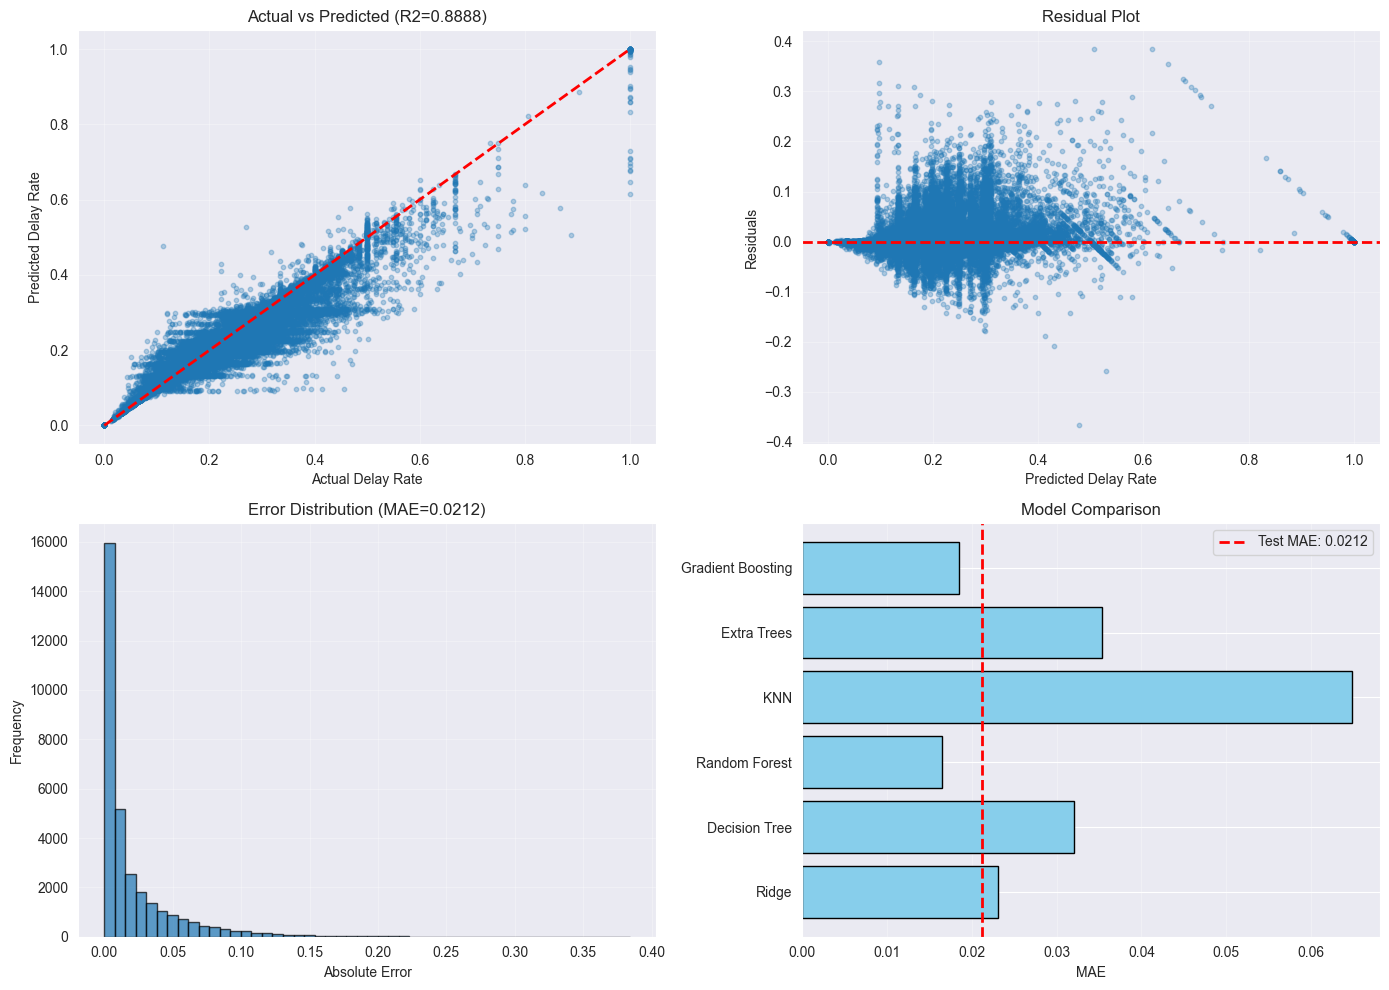

Visualization saved as model_evaluation.png


In [31]:
import matplotlib.pyplot as plt
import numpy as np
fig,axes=plt.subplots(2,2,figsize=(14,10))
axes[0,0].scatter(y_test,y_test_pred,alpha=0.3,s=10)
axes[0,0].plot([0,1],[0,1],'r--',lw=2)
axes[0,0].set_xlabel('Actual Delay Rate')
axes[0,0].set_ylabel('Predicted Delay Rate')
axes[0,0].set_title(f'Actual vs Predicted (R2={test_r2:.4f})')
axes[0,0].grid(True,alpha=0.3)
residuals=y_test-y_test_pred
axes[0,1].scatter(y_test_pred,residuals,alpha=0.3,s=10)
axes[0,1].axhline(y=0,color='r',linestyle='--',lw=2)
axes[0,1].set_xlabel('Predicted Delay Rate')
axes[0,1].set_ylabel('Residuals')
axes[0,1].set_title('Residual Plot')
axes[0,1].grid(True,alpha=0.3)
axes[1,0].hist(errors,bins=50,edgecolor='black',alpha=0.7)
axes[1,0].set_xlabel('Absolute Error')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_title(f'Error Distribution (MAE={test_mae:.4f})')
axes[1,0].grid(True,alpha=0.3)
models_list=results_df['model'].tolist()
val_mae_list=results_df['val_mae'].tolist()
axes[1,1].barh(models_list,val_mae_list,color='skyblue',edgecolor='black')
axes[1,1].axvline(x=test_mae,color='red',linestyle='--',linewidth=2,label=f'Test MAE: {test_mae:.4f}')
axes[1,1].set_xlabel('MAE')
axes[1,1].set_title('Model Comparison')
axes[1,1].legend()
axes[1,1].grid(True,alpha=0.3,axis='x')
plt.tight_layout()
plt.savefig('model_evaluation.png',dpi=300,bbox_inches='tight')
plt.show()
print('Visualization saved as model_evaluation.png')